# Homework 4: Analyzing Rates of Sea Level Rise
In this homework, you'll investigate sea level change using data from the ECCO state estimate. You'll look at spatial differences over the past few decades and then compare how sea level on the California coast compares to the global mean.

Begin by importing the modules you'll need for this notebook:

In [1]:
# import packages here
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import pandas as pd
import matplotlib.dates as mdates
from scipy.stats import linregress

## Part 1: Download Sea Surface Height Data
To begin this exercise, download all of the available sea surface height data (1992-2017) from the ECCO Version 4 Release 4 output. There are several different variables for sea surface height pertaining to different components and corrections. In this homework, we'll use the `SSHDYN` variable which is equivalent to what satellites would measure from space.

To obtain the data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes.

In [2]:
# define the path to the folder where the SSH data has been download on your machine
ssh_folder = 'E:\CS185C\data\homework_4_data\Version4\Release4\interp_monthly\SSHDYN'

## Part 2: Plot Total Sea Level Rise 1992-2017
As a first look into how sea level has changed in the past several decades, we'll look at the differences between two time periods at the beginning and end of the available model output: January 1992 and January 2017. It is important to use the same month because variations in sea level also have a seasonal cycle (as we'll see below). Begin by reading in the data:

In [3]:
# read in the longitude, latitude, and model ssh grid in January 1992 (SSHDYN_1992_01.nc)
def get_nc_path(year, month):
    return f"{ssh_folder}\\SSHDYN_{year}_{month:02d}.nc"
    
data_1992 = nc4.Dataset(get_nc_path(1992, 1))
data_2017 = nc4.Dataset(get_nc_path(2017, 1))

# read in the model ssh grid in January 2017 (SSHDYN_2017_01.nc)
ssh_1992 = data_1992.variables['SSHDYN'][0]  
ssh_2017 = data_2017.variables['SSHDYN'][0]  


Now, make a plot of the difference between January 2017 and January 1992. Be sure to add a colorbar with a divergent colormaps and set the color bounds to be equal in the positive and negative directions.

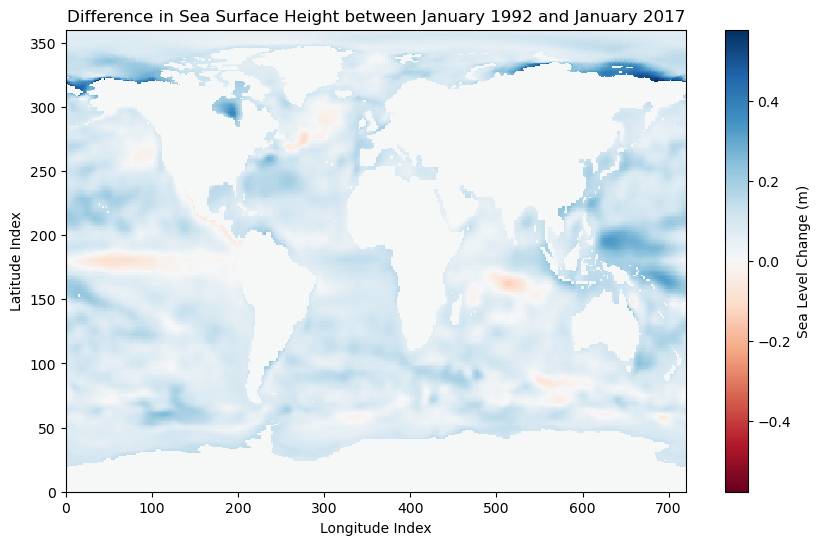

In [4]:
# make a plot of the differences between 2017 and 1992
ssh_difference = ssh_2017 - ssh_1992
plt.figure(figsize=(10, 6))
plt.pcolormesh(ssh_difference, cmap='RdBu', vmin=-np.max(np.abs(ssh_difference)), vmax=np.max(np.abs(ssh_difference)))
plt.colorbar(label='Sea Level Change (m)')
plt.title('Difference in Sea Surface Height between January 1992 and January 2017')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.show()

### Questions:
Where are the largest increases in sea level observed between these two time periods? Are there any locations on the globe where sea level has fallen? If so, where?

Answer: The largest increases in sea level between the two time periods are the Western Pacific Ocean and the Indian Ocean, near the Bay of Bengal area. The sea levels have fallen in some parts of the Eastern Pacific Ocean and around some parts of the Northern Indian Ocean

## Part 3: Create a Timeseries of Sea Surface Height in California
Next, we'll make a timeseries of sea surface height at a point off the California coast near San José. A close location in the model is at 37$^{\circ}$N, 122$^{\circ}$W. Begin by finding the closest row and column in the model grid to this longitude and latitude.

In [5]:
# define the latitude and longitude
lon = -122
lat = 37

# find the row and column closest to the location of the point off the CA coast
# note that you have already read in the longitude and latitude if the grid to make the plot above
lon_array = data_1992.variables['longitude'][:]
lat_array = data_1992.variables['latitude'][:]
def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = np.abs(array - value).argmin()
    return idx
ix = find_nearest_index(lon_array, lon)
iy = find_nearest_index(lat_array, lat)

C:\Users\shell\AppData\Local\Temp\ipykernel_1272\1658827142.py:7: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  lon_array = data_1992.variables['longitude'][:]
C:\Users\shell\AppData\Local\Temp\ipykernel_1272\1658827142.py:8: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  lat_array = data_1992.variables['latitude'][:]


Now, armed with your sample location, loop through each sea surface height file to make a timeseries of sea level rise between 1992 and 2017. Every time you access a file, sample the model grid at the row and column you identified above.

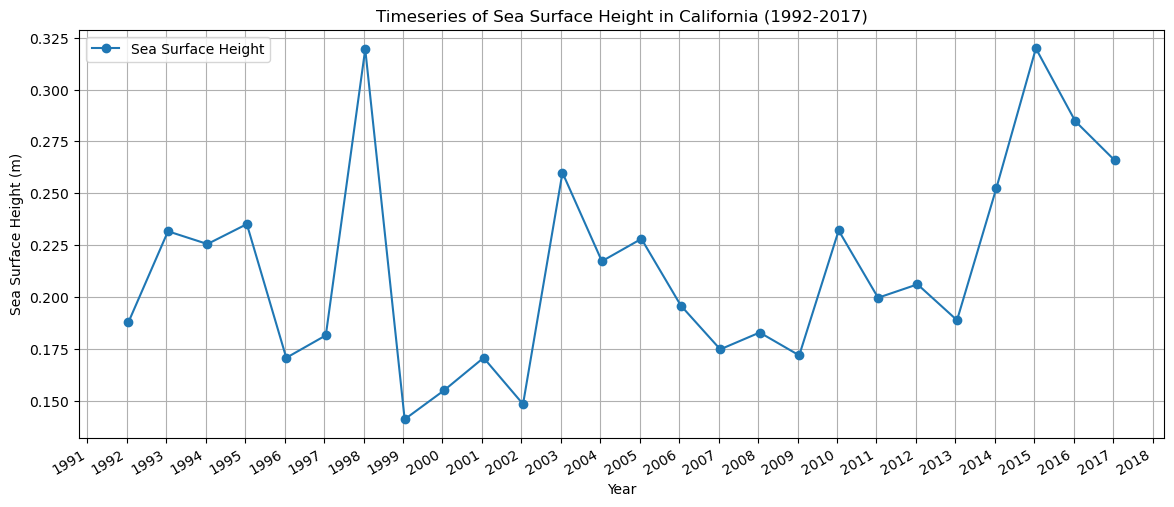

In [6]:
# create a timeseries of ssh at the point above by looping through all of the ssh files
# each time through the loop, sample the ssh grid at the row and column identified above
# your timeseries should be an (N,2) array with time in the first column and ssh values in the second
time_series = []
for year in range(1992, 2018):
    data_path = get_nc_path(year, 1)
    with nc4.Dataset(data_path) as data:
        time_var = data.variables['time']
        times = nc4.num2date(time_var[:], units=time_var.units)
        ssh_value = data.variables['SSHDYN'][0, iy, ix]  
        time_series.append([pd.to_datetime(str(times[0])), ssh_value])  
time_series = np.array(time_series, dtype=object)
plt.figure(figsize=(14, 6))
plt.plot(time_series[:, 0], time_series[:, 1], label='Sea Surface Height', marker='o', linestyle='-')
plt.title('Timeseries of Sea Surface Height in California (1992-2017)')
plt.xlabel('Year')
plt.ylabel('Sea Surface Height (m)')
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # Automatic date rotation
plt.legend()
plt.show()

## Part 4: Create a Timeseries of Global Mean Sea Surface Height
Next, make a timeseries of sea surface height averaged across the globe. Your loop should look quite similar to that above - you'll just need to make a slight change to average across the whole ocean rather than sampling at a single point.

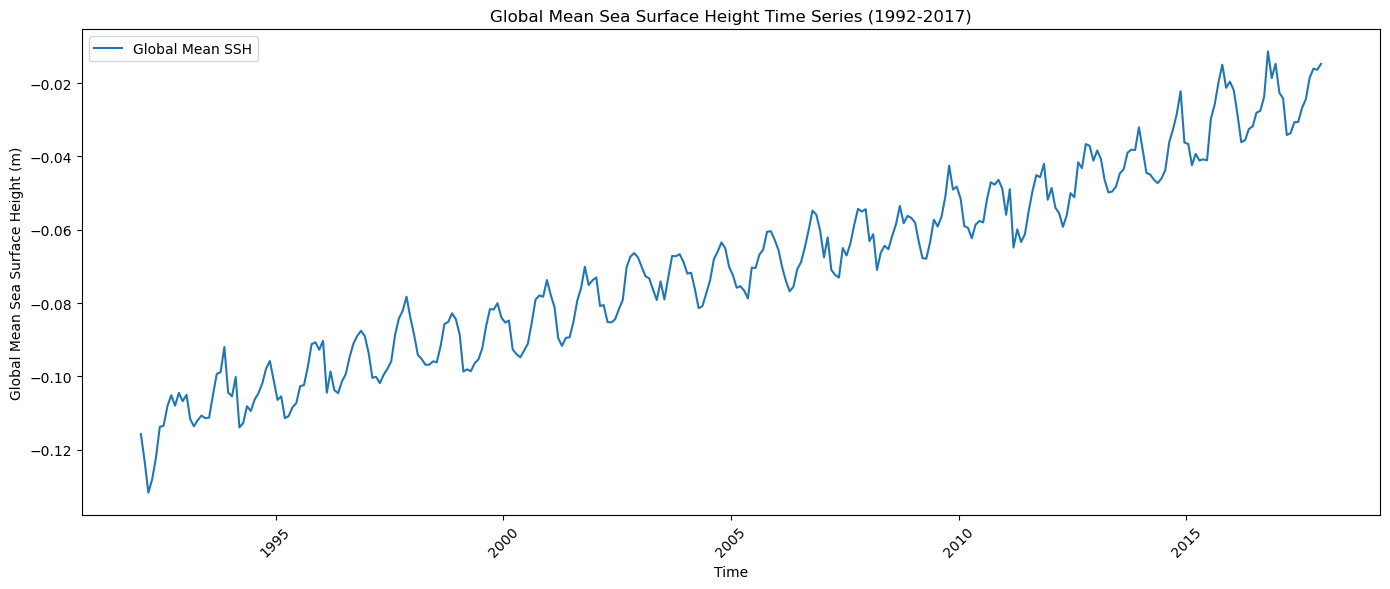

In [7]:
# create a timeseries of the global mean ssh by looping through all of the ssh files
# each time through the loop, take the mean of the ssh grid at the row and column identified above
# when you take the mean, be sure to exclude 0 values, which pertain to land
# your timeseries should be an (N,2) array with time in the first column and ssh values in the second
global_ssh_time_series = []
for year in range(1992, 2018):
    for month in range(1, 13):
        data_path = get_nc_path(year, month)
        with nc4.Dataset(data_path) as data:
            ssh_grid = data.variables['SSHDYN'][0] 
            valid_ssh_values = ssh_grid[ssh_grid != 0] 
            mean_ssh = np.mean(valid_ssh_values)  
            time_value = nc4.num2date(data.variables['time'][0], units=data.variables['time'].units) 
            global_ssh_time_series.append([time_value, mean_ssh])  
global_ssh_time_series = np.array(global_ssh_time_series, dtype=object)
dates = [mdates.date2num(date) for date in global_ssh_time_series[:, 0]]
ssh_values = global_ssh_time_series[:, 1]
plt.figure(figsize=(14, 6))
plt.plot(dates, ssh_values, '-', label='Global Mean SSH')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
plt.xlabel('Time')
plt.ylabel('Global Mean Sea Surface Height (m)')
plt.title('Global Mean Sea Surface Height Time Series (1992-2017)')
plt.xticks(rotation=45) 
plt.legend()
plt.tight_layout()
plt.show()


## Part 5: Compute Trends in Sea Surface Height
To compare the two timeseries, compute trends by fitting a line to each timeseries and examining the slope. Print out each trend in mm/yr, rounded to 2 decimal places. Note that the units of sea surface height are in meters.

In [8]:
# compute the trends in SLR by fitting a line to the CA and the global mean timeseries
def prepare_data_for_trend(timeseries):
    years = mdates.date2num(timeseries[:, 0])
    years = (years - years.min()) / 365.25
    ssh_values = timeseries[:, 1].astype(float)
    return years, ssh_values
ca_years, ca_ssh_values = prepare_data_for_trend(time_series)
global_years, global_ssh_values = prepare_data_for_trend(global_ssh_time_series)
ca_slope, ca_intercept, ca_r_value, ca_p_value, ca_std_err = linregress(ca_years, ca_ssh_values)
global_slope, global_intercept, global_r_value, global_p_value, global_std_err = linregress(global_years, global_ssh_values)
ca_slope_mm_yr = ca_slope * 1000  
global_slope_mm_yr = global_slope * 1000 

# Print out the statistics in mm/yr for each timeseries
print(f"California SLR Trend: {ca_slope_mm_yr:.2f} mm/yr")
print(f"Global Mean SLR Trend: {global_slope_mm_yr:.2f} mm/yr")

California SLR Trend: 1.98 mm/yr
Global Mean SLR Trend: 3.38 mm/yr


### Question:
How does the trend in sea level rise in California compare to the global mean rate?

Answer: the trend in sea level rise in California is 1.98 mm/yr which is slower compared to the global mean rate of 3.38 mm/yr


## Part 6: Plot the Timeseries of Sea Surface Height
Finally, plot the two timeseries on the same plot along with their trend lines. Be sure to label your axes and include a legend.

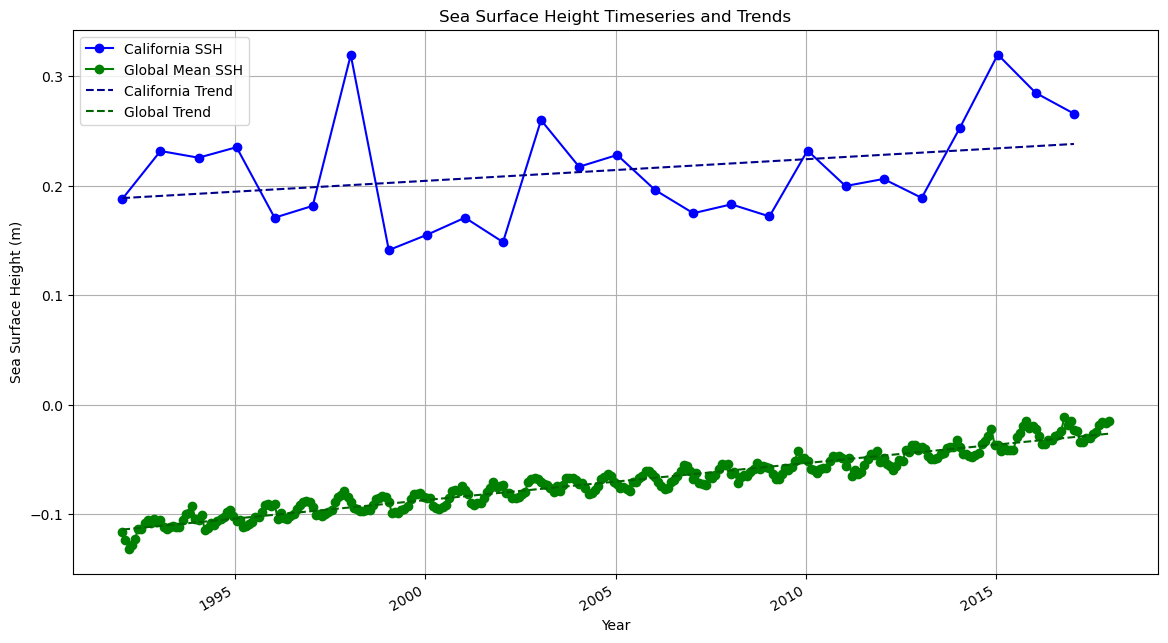

In [9]:
# create your plot here
def calculate_trend_line(dates, slope, intercept):
    return dates * slope + intercept
ca_dates = mdates.date2num(time_series[:, 0])  # Convert dates to matplotlib date format
global_dates = mdates.date2num(global_ssh_time_series[:, 0])
ca_years = (ca_dates - ca_dates.min()) / 365.25
global_years = (global_dates - global_dates.min()) / 365.25
ca_trend_line = calculate_trend_line(ca_years, ca_slope, ca_intercept)
global_trend_line = calculate_trend_line(global_years, global_slope, global_intercept)
plt.figure(figsize=(14, 8))
plt.plot(ca_dates, time_series[:, 1], label='California SSH', marker='o', linestyle='-', color='blue')
plt.plot(global_dates, global_ssh_time_series[:, 1], label='Global Mean SSH', marker='o', linestyle='-', color='green')
plt.plot(ca_dates, ca_trend_line, label='California Trend', linestyle='--', color='darkblue')
plt.plot(global_dates, global_trend_line, label='Global Trend', linestyle='--', color='darkgreen')
plt.title('Sea Surface Height Timeseries and Trends')
plt.xlabel('Year')
plt.ylabel('Sea Surface Height (m)')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.show()

### Questions:

How do the timeseries for Calfiornia and the global mean compare? Comment on their variability. What are the two highest years of sea level in California? What oceanographic phenomenon happened during this time?

Answer: The timeseries data for California changed a lot more each year when compared to the global mean level which went up slowly. Californias sea level went up and down a lot because of local weather changes like the El Nino. The global sea level rised more smoothly as it kept on going up, which happens because as Earth is getting warmer, the ice is melting into the ocean. The two highest years of sea level in california was 2015 and 1998, during this time there was big El nino events which made the sea warmer and caused the water to rise. 